In [1]:
import os
import sys
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# PROJECT_FULL_PATH = "C:\\Users\\Luca\\Desktop\\MagistraleAI\\2nd_year\\Artificial Intelligence in Industry\\project"
# sys.path.append(PROJECT_FULL_PATH)


from data import PascalVOC2007, SynteticFigures, FROM_IDX_TO_LABEL
from models import vgg11_PascalVOC, vgg11_Syntetic, vgg_preprocess
from utils import (
    ERFUpsampling,
    ERFUpsamplingFast,
    SimpleUpsampling,
    _DeepLiftShap,
    _GradCAMPlusPlus,
)
from metrics import ROC_AUC, RoadCombined, Sensitivity, Infidelity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

model_PascalVOC = vgg11_PascalVOC()
model_PascalVOC.to(device)
# Load the pretrained weights
model_PascalVOC.load_state_dict(torch.load("VGG11_PascalVOC.pt", map_location=device))
model_PascalVOC.eval()

test_data_PascalVOC = PascalVOC2007("test", transform=vgg_preprocess)
test_data_PascalVOC_no_transform = PascalVOC2007(
    "test",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ]
    ),
)
train_data_PascalVOC = PascalVOC2007("train", transform=vgg_preprocess)

baseline_dist_PascalVOC = torch.cat(
    [train_data_PascalVOC[i][0].unsqueeze(0) for i in range(16)], dim=0
).to(device)



Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [4]:

model_Syntetic = vgg11_Syntetic()
model_Syntetic.to(device)
# Load the pretrained weights
model_Syntetic.load_state_dict(torch.load("VGG11_Synthetic.pt", map_location=device))
model_Syntetic.eval()

SYNTH_LABELS = {0: "Circle", 1: "Square", 2: "Triangle"}

denormalize = transforms.Compose(
    [
        transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    ]
)


class Binarize(object):
    def __init__(self):
        pass

    def __call__(self, img: torch.Tensor):
        # Sum over channels
        img = img.sum(dim=0)
        img[img > 0] = 1
        img[img <= 0] = 0

        return img.unsqueeze(0)


background_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]
)

mask_preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
    ]
)

background_path = os.path.join("data", "Waldo")

data_test_Syntetic = SynteticFigures(
    background_path=background_path,
    num_images=128,
    split="test",
    num_shapes_per_image=1,
    image_transform=vgg_preprocess,
    background_transform=background_transform,
    mask_preprocess=mask_preprocess,
    num_other_shapes=0,
    size_range=(80, 100),
)

data_test_Syntetic_no_transform = SynteticFigures(
    background_path=background_path,
    num_images=128,
    split="test",
    num_shapes_per_image=1,
    image_transform=transforms.Compose(
        [
            transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ]
    ),
    background_transform=background_transform,
    mask_preprocess=mask_preprocess,
    num_other_shapes=0,
    size_range=(80, 100),
)

data_train_Syntetic = SynteticFigures(
    background_path=background_path,
    num_images=16,
    split="train",
    num_shapes_per_image=1,
    image_transform=vgg_preprocess,
    background_transform=background_transform,
    mask_preprocess=mask_preprocess,
    num_other_shapes=0,
    size_range=(80, 100),
)

baseline_dist_Syntetic = torch.cat(
    [data_train_Syntetic[i][0].unsqueeze(0) for i in range(16)], dim=0
).to(device)

In [32]:
def calculate_attribution(
    dataset: str,
    image_index: int,
    layer_index: int,
    attribution_name: str,
    upsample_name: str,
    return_torch: bool = False,
) -> np.ndarray:
    """Given an image index, layer index, attribution method, and upsampling method, calculate the attribution map for the image.

    Args:
        dataset (str): The dataset to use for the test data.
        image_index (int): The index of the image in the test set.
        layer_index (int): The index of the layer in the model.
        attribution_name (str): The name of the attribution method.
        upsample_name (str): The name of the upsampling method.

    Returns:
        tuple(np.ndarray, np.ndarray): The input image and the attribution map.

    """
    if dataset.lower() == "PascalVOC2007".lower():
        test_data = test_data_PascalVOC
        test_data_no_transform = test_data_PascalVOC_no_transform
        model = model_PascalVOC
        baseline_dist = baseline_dist_PascalVOC
        LABELS = FROM_IDX_TO_LABEL

        image, label = test_data[image_index]

    elif dataset.lower() == "SynteticFigures".lower():
        test_data = data_test_Syntetic
        test_data_no_transform = data_test_Syntetic_no_transform
        model = model_Syntetic
        baseline_dist = baseline_dist_Syntetic
        LABELS = SYNTH_LABELS

        image, mask, label = test_data[image_index]
        label = torch.tensor([label])
        print(label)
    else:
        raise ValueError(
            f"Invalid dataset name, got {dataset}. Valid options are PascalVOC2007 and SynteticFigures."
        )

    # Calculate the attribution maps and return it
    images = image.unsqueeze(0).to(device)

    layer = model.features[layer_index]

    if attribution_name.lower() == "DeepLiftShap".lower():
        attribution = _DeepLiftShap()
    elif attribution_name.lower() == "GradCAMPlusPlus".lower():
        attribution = _GradCAMPlusPlus(model, layer)
    else:
        raise ValueError(
            f"Invalid attribution name, got {attribution_name}. Valid options are _DeepLiftShap and _GradCAMPlusPlus."
        )

    if upsample_name.lower() == "BilinearUpsampling".lower():
        upsample = SimpleUpsampling((224, 224))
    elif upsample_name.lower() == "ERFUpsampling".lower():
        upsample = ERFUpsampling(model, layer, device)
    elif upsample_name.lower() == "ERFUpsamplingFast".lower():
        upsample = ERFUpsamplingFast(model, layer, device)
    else:
        raise ValueError(
            f"Invalid upsample name, got {upsample_name}. Valid options are BilinearUpsampling, ERFUpsampling, and ERFUpsamplingFast."
        )

    attribution_map = attribution.attribute(
        model=model,
        input_tensor=images,
        layer=layer,
        target=label.to(device),
        baseline_dist=baseline_dist,
    )

    attribution_map_upsampled = upsample(attribution_map, images)

    image = (
        test_data_no_transform[image_index][0].permute(1, 2, 0).detach().cpu().numpy()
    )

    # Convert attribution and image to numpy
    if not return_torch:
        attribution_map_upsampled = (
            attribution_map_upsampled.squeeze(0).detach().cpu().numpy()
        )
        return (
            image,
            [
                attribution_map.squeeze(0).detach().cpu().numpy(),
                attribution_map_upsampled,
            ],
            LABELS[label.item()],
        )
    else:
        return (
            image,
            [attribution_map.squeeze(0), attribution_map_upsampled],
            LABELS[label.item()],
        )


def calculate_metrics(
    dataset: str,
    image_index: int,
    layer_index: int,
    attribution_name: str,
    upsample_name: str,
    metrics: list[str],
):
    _, attribution_maps, _ = calculate_attribution(
        dataset,
        image_index,
        layer_index,
        attribution_name,
        upsample_name,
        return_torch=True,
    )

    if dataset.lower() == "PascalVOC2007".lower():
        model = model_PascalVOC
        test_data = test_data_PascalVOC
        baseline_dist = baseline_dist_PascalVOC

        image, label = test_data[image_index]
        mask = None
    elif dataset.lower() == "SynteticFigures".lower():
        model = model_Syntetic
        test_data = data_test_Syntetic
        baseline_dist = baseline_dist_Syntetic

        image, mask, label = test_data[image_index]
        mask = mask.unsqueeze(0)
        label = torch.tensor([label])
    else:
        raise ValueError(
            f"Invalid dataset name, got {dataset}. Valid options are PascalVOC2007 and SynteticFigures."
        )

    images = image.unsqueeze(0).to(device)

    layer = model.features[layer_index]
    if attribution_name.lower() == "DeepLiftShap".lower():
        attribute_method = _DeepLiftShap()
    elif attribution_name.lower() == "GradCAMPlusPlus".lower():
        attribute_method = _GradCAMPlusPlus(model, layer)
    else:
        raise ValueError(
            f"Invalid attribution name, got {attribution_name}. Valid options are _DeepLiftShap and _GradCAMPlusPlus."
        )

    results = {}

    metrics_to_run = []
    for metric_name in metrics:
        if metric_name.lower() == "RoadCombined".lower():
            metrics_to_run.append(RoadCombined())
        elif metric_name.lower() == "Sensitivity".lower():
            metrics_to_run.append(Sensitivity())
        elif metric_name.lower() == "Infidelity".lower():
            metrics_to_run.append(Infidelity())
        elif metric_name.lower() == "ROC_AUC".lower():
            continue
        else:
            raise ValueError(
                f"Invalid metric name, got {metric_name}. Valid options are RoadCombined, Sensitivity, Infidelity and ROC_AUC."
            )

    for metric in metrics_to_run:
        metric_res = metric(
            model=model,
            test_images=images,
            saliency_maps=attribution_maps[1],
            class_idx=label,
            attribution_method=attribute_method,
            device=device,
            baseline_dist=baseline_dist,
            layer=layer,
            mask=mask,
        )

        if type(metric_res) is torch.Tensor:
            metric_res = metric_res.detach().cpu().numpy()

        results[metric.__class__.__name__] = metric_res

    if "ROC_AUC" in metrics:
        if dataset.lower() == "SynteticFigures".lower():
            roc_auc = ROC_AUC()(
                saliency_maps=attribution_maps[1],
                mask=mask,
            )

            results["ROC_AUC"] = roc_auc

    return results


def calculate_road_images(
    dataset: str,
    image_index: int,
    layer_index: int,
    attribution_name: str,
    upsample_name: str,
):
    _, attribution_maps, _ = calculate_attribution(
        dataset,
        image_index,
        layer_index,
        attribution_name,
        upsample_name,
        return_torch=True,
    )

    if dataset.lower() == "PascalVOC2007".lower():
        model = model_PascalVOC
        test_data = test_data_PascalVOC
        baseline_dist = baseline_dist_PascalVOC

        image, label = test_data[image_index]
        mask = None
    elif dataset.lower() == "SynteticFigures".lower():
        model = model_Syntetic
        test_data = data_test_Syntetic
        baseline_dist = baseline_dist_Syntetic

        image, mask, label = test_data[image_index]
        mask = mask.unsqueeze(0)
        label = torch.tensor([label])
    else:
        raise ValueError(
            f"Invalid dataset name, got {dataset}. Valid options are PascalVOC2007 and SynteticFigures."
        )

    images = image.unsqueeze(0).to(device)

    layer = model.features[layer_index]
    if attribution_name.lower() == "DeepLiftShap".lower():
        attribute_method = _DeepLiftShap()
    elif attribution_name.lower() == "GradCAMPlusPlus".lower():
        attribute_method = _GradCAMPlusPlus(model, layer)
    else:
        raise ValueError(
            f"Invalid attribution name, got {attribution_name}. Valid options are _DeepLiftShap and _GradCAMPlusPlus."
        )

    scores, visualization_results = RoadCombined()(
        model=model,
        test_images=images,
        saliency_maps=attribution_maps[1],
        class_idx=label,
        attribution_method=attribute_method,
        device=device,
        return_visualization=True,
        return_mean=False,
    )

    # for key in visualization_results:
    # print(f"{key} = {visualization_results[key]}")
    # print(type(visualization_results[key]))
    for i in range(len(visualization_results)):
        # for image in visualization_results[key]:
        # visualization_results[i] = (
        #     denormalize(visualization_results[i])
        #     .permute(1, 2, 0)
        #     .detach()
        #     .cpu()
        #     .numpy()
        # )
        visualization_results[i] = visualization_results[i].detach().cpu()

    # # print(f"visualization_results.shape = {visualization_results.shape}")

    return scores, visualization_results


In [77]:
scores, visualization_results = calculate_road_images(
    dataset="SynteticFigures",
    image_index=43,
    layer_index=20,
    attribution_name="DeepLiftShap",
    upsample_name="ERFUpsamplingFast",
)

tensor([0])


c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


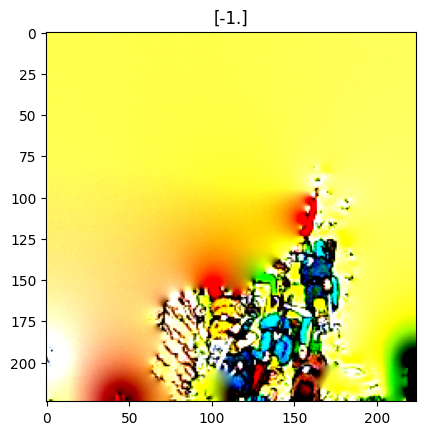

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


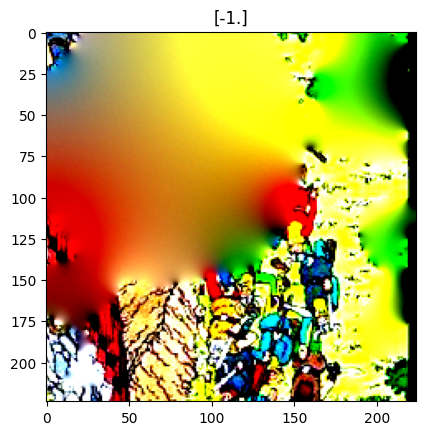

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


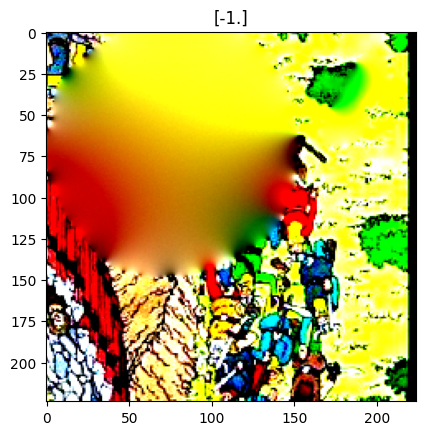

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


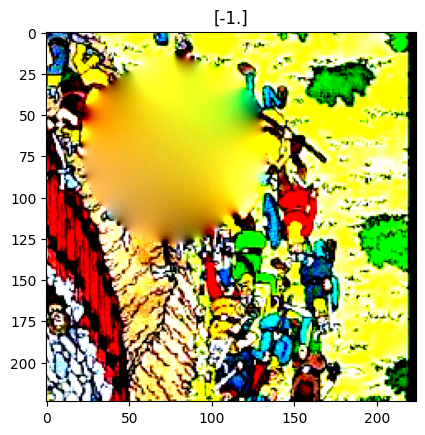

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


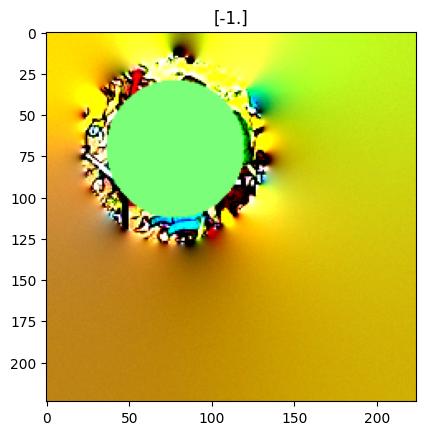

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


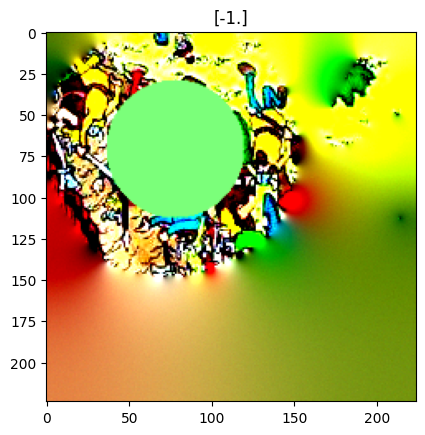

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


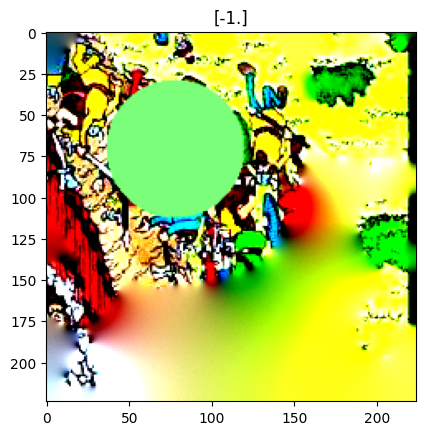

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


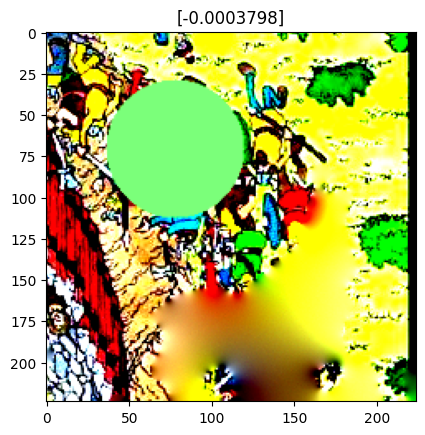

In [78]:
from matplotlib import pyplot as plt
for i, image in enumerate(visualization_results):
    print(image.shape)
    plt.title(scores[i])
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


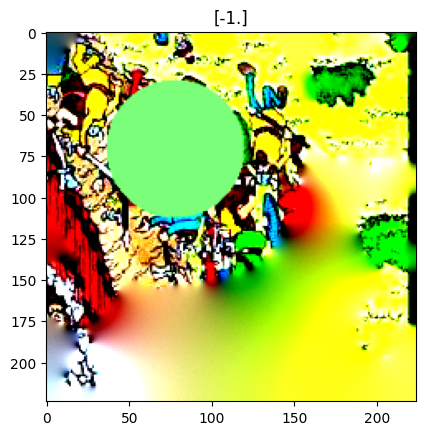

In [81]:
sus_image = visualization_results[-2]
plt.imshow(sus_image.permute(1, 2, 0))
plt.title(scores[-2])
plt.show()

In [82]:
model_Syntetic.eval()
image, mask, label = data_test_Syntetic[43]
output = model_Syntetic(image.unsqueeze(0).to(device))
print(output)

tensor([[ 25.0886,   0.4686, -23.4480]], grad_fn=<AddmmBackward0>)


In [83]:
sus_output = model_Syntetic(sus_image.unsqueeze(0).to(device))
print(sus_output)

tensor([[  0.2503,  29.3183, -26.3379]], grad_fn=<AddmmBackward0>)


In [73]:
attr = _GradCAMPlusPlus(model_Syntetic, model_Syntetic.features[20])
cams = attr.attribute(input_tensor=sus_image.unsqueeze(0).to(device),
     model=model_Syntetic,
     layer=model_Syntetic.features[20],
    target=[0])

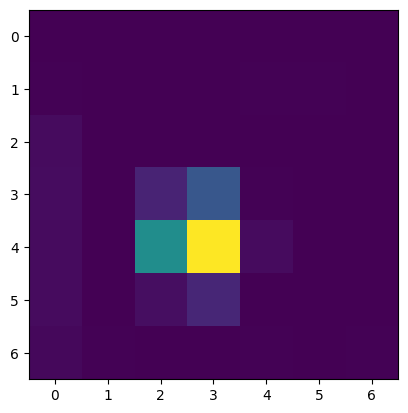

In [74]:
plt.imshow(cams[0][0].detach().cpu())
plt.show()